# Import Required Libraries
Import the necessary libraries for generating and analyzing ECG data.

In [4]:
%pip install numpy matplotlib scipy

import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
from scipy.signal import find_peaks

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 64.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 66.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 59.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


# Generate Artificial ECG Data
This section defines a function to generate synthetic ECG data, including noise and artifacts, to simulate real-world conditions.

In [5]:
def generate_ecg_data(duration, sampling_rate=250):
    def generate_ecg_pulse(duration, sampling_rate):
        t = np.linspace(0, duration, int(duration * sampling_rate), endpoint=False)
        # P wave
        p_wave = 0.15 * np.sin(2 * np.pi * 1.5 * t) * np.exp(-((t - 0.1) ** 2) / 0.005)
        # QRS complex
        qrs_complex = np.zeros_like(t)
        qrs_complex[(t > 0.2) & (t < 0.25)] = -0.3
        qrs_complex[(t > 0.25) & (t < 0.3)] = 1.0
        qrs_complex[(t > 0.3) & (t < 0.35)] = -0.2
        # T wave
        t_wave = 0.3 * np.sin(2 * np.pi * 0.75 * (t - 0.45)) * np.exp(-((t - 0.45) ** 2) / 0.015)
        # Combine all components
        pulse = p_wave + qrs_complex + t_wave
        # Add high-frequency noise to the pulse
        high_freq_noise = 0.05 * np.sin(2 * np.pi * 50 * t)
        pulse += high_freq_noise
        return pulse

    # Generate a single ECG pulse
    single_pulse = generate_ecg_pulse(0.8, sampling_rate)

    # Repeat the pulse to create a longer ECG signal
    num_pulses = int(duration / 0.8)
    ecg_data = np.tile(single_pulse, num_pulses)

    # Add more noise to make it more realistic
    noise = np.random.normal(0, 0.05, len(ecg_data))  # Increased noise amplitude
    ecg_data += noise

    # Add baseline wander
    t = np.linspace(0, duration, len(ecg_data), endpoint=False)
    baseline_wander = 0.1 * np.sin(2 * np.pi * 0.1 * t)
    ecg_data += baseline_wander

    # Add power line interference
    power_line_interference = 0.05 * np.sin(2 * np.pi * 60 * t)  # 60 Hz interference
    ecg_data += power_line_interference

    # Ensure the length of ecg_data matches the desired duration
    ecg_data = ecg_data[:int(duration * sampling_rate)]

    return ecg_data

ecg_data = generate_ecg_data(10, 250)

# Visualize the Raw ECG Signal
Plot the generated ECG signal to observe its raw form, including noise and artifacts.

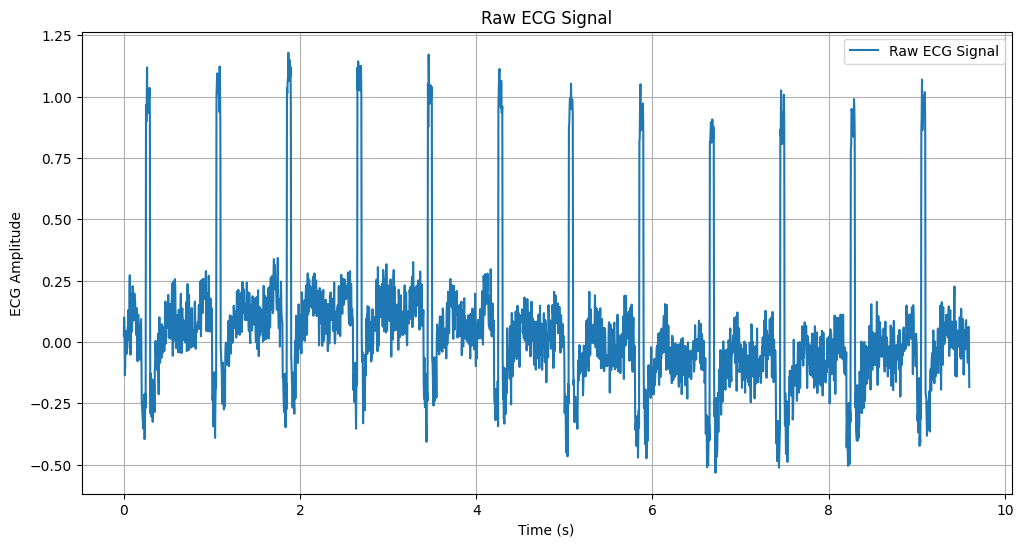

In [6]:
sampling_rate = 250
time = np.arange(len(ecg_data)) / sampling_rate
plt.figure(figsize=(12, 6))
plt.plot(time, ecg_data, label='Raw ECG Signal')
plt.title('Raw ECG Signal')
plt.xlabel('Time (s)')
plt.ylabel('ECG Amplitude')
plt.grid()
plt.legend()
plt.show()

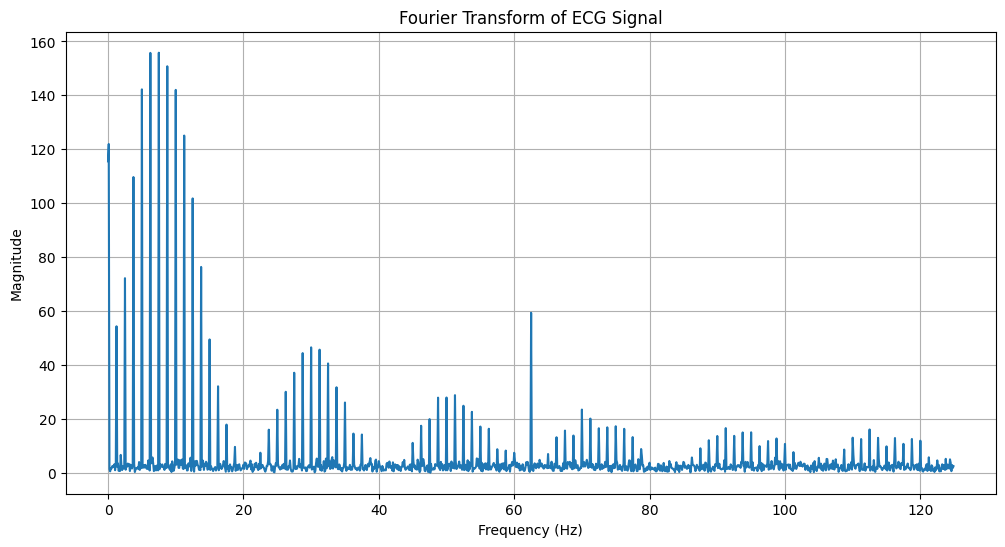

In [7]:
# Compute the Fourier Transform
ecg_fft = fft(ecg_data)
magnitude = np.abs(ecg_fft)

# Generate the frequency array
freqs = np.fft.fftfreq(len(ecg_data), d=1/sampling_rate)

# Plot only the positive frequencies
positive_freqs = freqs[:len(freqs)//2]
positive_magnitude = magnitude[:len(magnitude)//2]

plt.figure(figsize=(12, 6))
plt.plot(positive_freqs, positive_magnitude)
plt.title('Fourier Transform of ECG Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid()
plt.show()

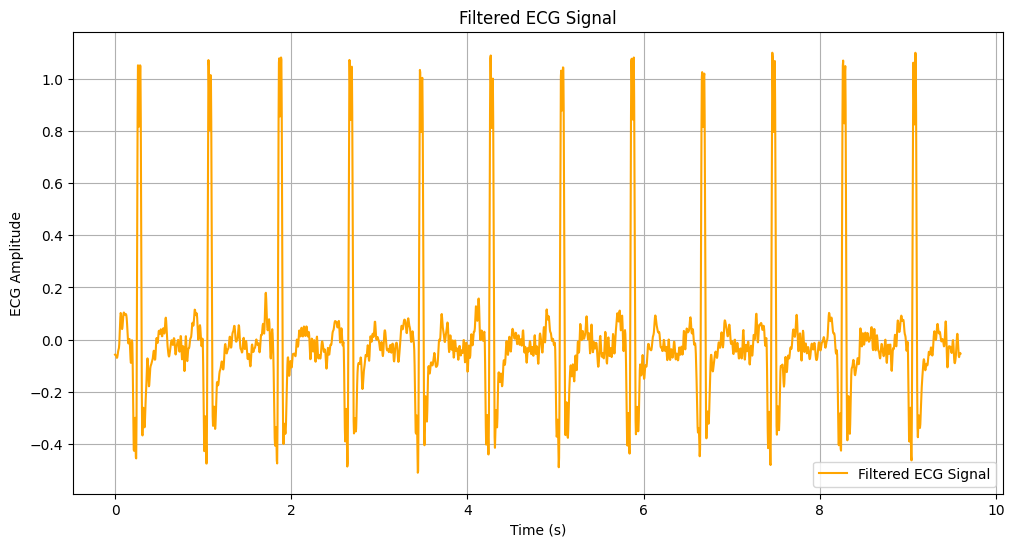

In [8]:
# Define the frequency range for the bandpass filter
low_cutoff = 0.5  # Lower bound in Hz
high_cutoff = 40.0  # Upper bound in Hz

# Create a mask to preserve frequencies within the range
bandpass_mask = (np.abs(freqs) >= low_cutoff) & (np.abs(freqs) <= high_cutoff)

# Apply the mask to the Fourier-transformed signal
filtered_fft = ecg_fft * bandpass_mask

# Reconstruct the filtered ECG signal using the inverse Fourier transform
filtered_ecg = np.real(ifft(filtered_fft))

# Plot the filtered ECG signal
plt.figure(figsize=(12, 6))
plt.plot(time, filtered_ecg, label='Filtered ECG Signal', color='orange')
plt.title('Filtered ECG Signal')
plt.xlabel('Time (s)')
plt.ylabel('ECG Amplitude')
plt.grid()
plt.legend()
plt.show()

In [10]:
# Detect R-peaks in the filtered ECG signal
peaks, _ = find_peaks(filtered_ecg, height=0.5, distance=sampling_rate * 0.6)  # Adjust height and distance as needed

# Calculate the time intervals between successive R-peaks
r_peak_intervals = np.diff(peaks) / sampling_rate  # Convert intervals to seconds

# Compute the heart rate in beats per minute (BPM)
average_interval = np.mean(r_peak_intervals)
heart_rate_bpm = 60 / average_interval

print(f"Heart Rate: {heart_rate_bpm:.2f} BPM")

Heart Rate: 75.00 BPM


After analyzing the ECG signal, I was able to filter a lot of the noises form the raw ECG signal using a bandpass filter to isolate frequencies between 0.5 Hz and 40 Hz, removing baseline wander and high-frequency noise. This helped isolate heartbeat features such as the QRS complex. The Fourier Transform highlighted strong frequency components of the signal, being around 1 Hz, while the inverse transform reconstructed the filtered signal. Once the ECG signals were filtered, I used peak detection to find the R-peaks and the average time between these peaks to then determine heart rate, which was found to be 75 BPM. 